# Breast Cancer Ultrasound Semantic Segmentation and Classification

<img src='https://www.researchgate.net/publication/337431084/figure/fig1/AS:839678529908737@1577206370028/Samples-of-Ultrasound-breast-images-dataset.ppm'>

## **Semantic Image Segmentation** 
is to label each pixel of an image with a corresponding class of what is being represented. Because we're predicting for every pixel in the image, this task is commonly referred to as dense prediction.

<img src = 'https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-17-at-7.42.16-PM.png'>

## Dataset
The used dataset is Breast <a href ='https://www.kaggle.com/aryashah2k/breast-ultrasound-images-dataset'>Ultrasound Images Dataset</a> found on Kaggle. 

The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

Dataset Sampling:
* 446 Bengin
* 133 Normal 
* 210 Malignant

# <center>**Segmentation**</center>
This part will be specifically for generating a mask on the cancer mass in order to classify it later on. Will be using `UNET` architecture for applying the semantic segmentation.

### UNET Architecture and Training
*  The UNET  architecture contains two paths. First path is the contraction path (also called as the encoder) which is used to capture the context in the image.
* The encoder is just a traditional stack of convolutional and max pooling layers. 
* The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. 
* Thus it is an end-to-end fully convolutional network (FCN)
* In the original paper, the UNET is described as follows:

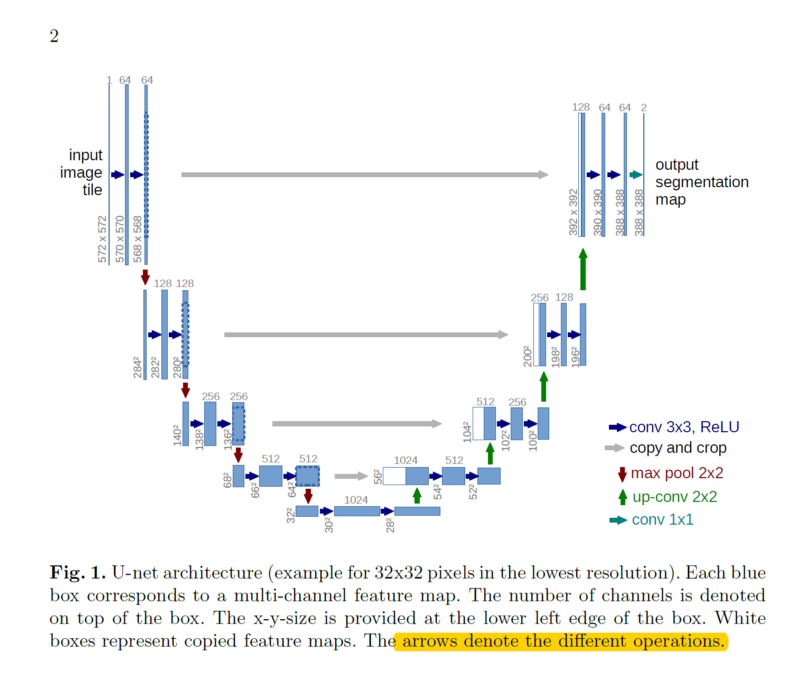

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Data

In [3]:
# path to zip file
DATA_PATH = '/content/gdrive/MyDrive/Projects/Breast-Cancer-Ultrasound-Segmentation/data/archive.zip'

In [4]:
# unzip data
!unzip '/content/gdrive/MyDrive/Projects/Breast-Cancer-Ultrasound-Segmentation/data/archive.zip'

Archive:  /content/gdrive/MyDrive/Projects/Breast-Cancer-Ultrasound-Segmentation/data/archive.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_

In [5]:
from keras.preprocessing.image import img_to_array

In [6]:
def num (image) :
    val = 0
    
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    
    return val

In [7]:
# initialize cancer samples to numpy arrays
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m = np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [8]:
path = '/content/Dataset_BUSI_with_GT/'

### Assign each image to its corresponding class

In [9]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

## Visualize Data

for visualizations put the sample from the dataset in `tf.squeeze` function to avoid dimensionality errors as stated <a href = 'https://newbedev.com/invalid-dimension-for-image-data-in-plt-imshow'>here</a>



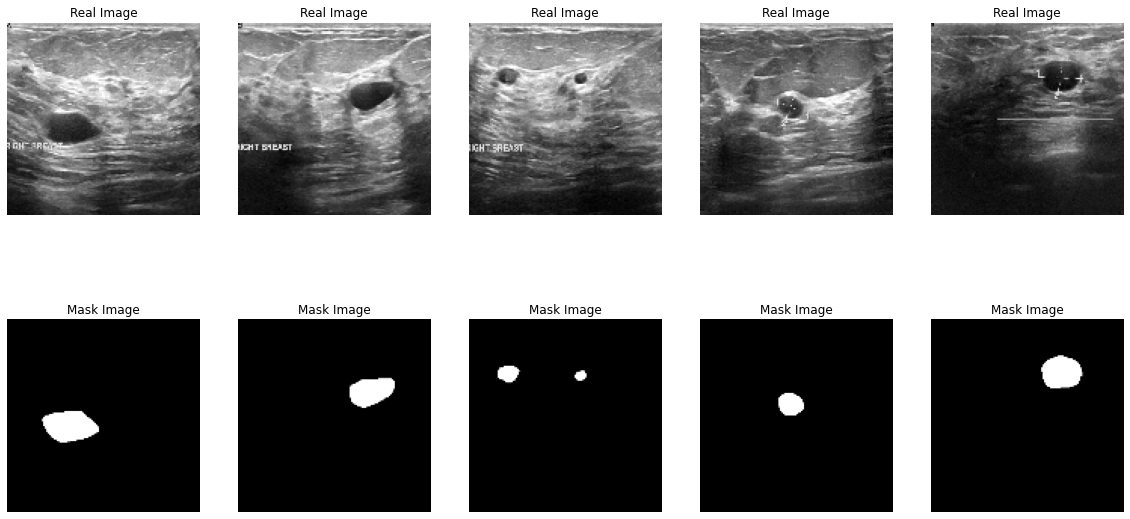

In [10]:
plt.figure(figsize = (20,10))

for i in range(5) :
    plt.subplot(2,5,i+1)
    plt.imshow(tf.squeeze(X_b[i+1]), 'gray')
    plt.title('Real Image')
    plt.axis('off')

for i in range(5) :
    plt.subplot(2,5,i+6)
    plt.imshow(tf.squeeze(y_b[i+1]), 'gray')
    plt.title('Mask Image')
    plt.axis('off')
plt.show()

## Prepare and Split Data

In [11]:
# input and target
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [12]:
# normlaize
X /= 255.0
y /= 255.0

In [13]:
print('Input Shape: ', X.shape)
print('Traget Shape: ', y.shape)

Input Shape:  (780, 128, 128, 1)
Traget Shape:  (780, 128, 128, 1)


In [14]:
# target shouldnt be > 1
y[y > 1.0] = 1.0

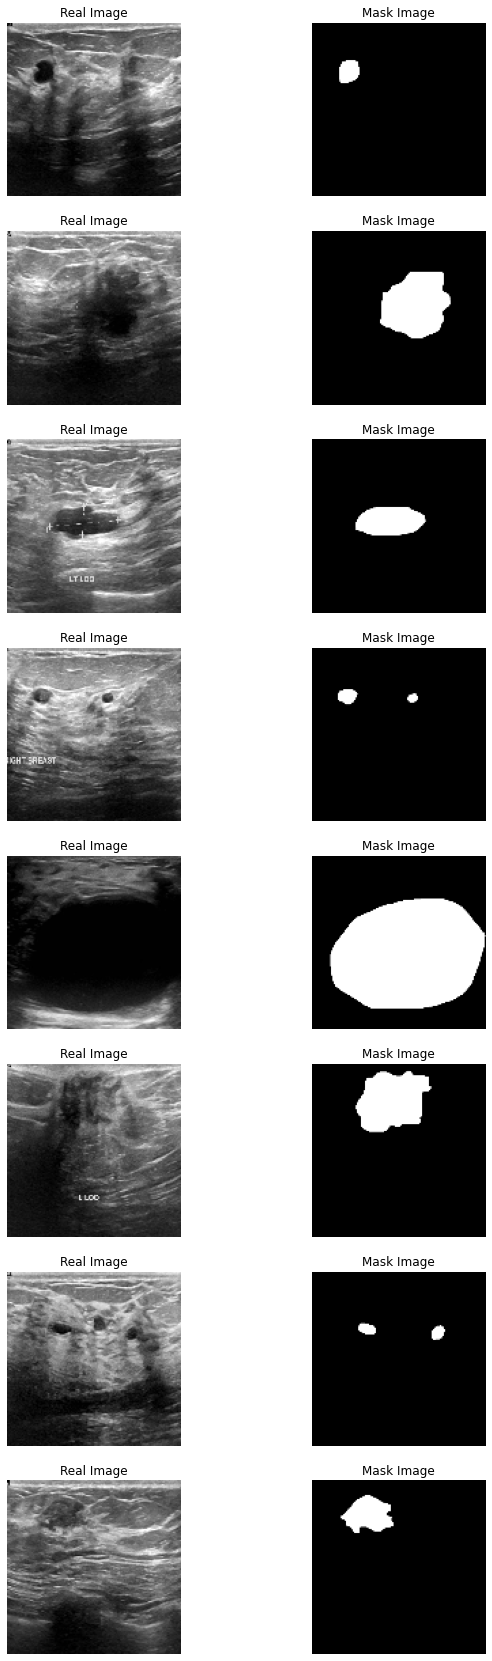

In [15]:
plt.figure(figsize = (10,30))
i = 0
while i < 16 :
    
    x = np.random.randint(0,780)
    
    plt.subplot(8,2,i+1)
    plt.imshow(tf.squeeze(X[x]),'gray')
    plt.title('Real Image')
    plt.axis('off')
    
    plt.subplot(8,2,i+2)
    plt.imshow(tf.squeeze(y[x]),'gray')
    plt.title('Mask Image')
    plt.axis('off')
    
    i += 2
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 1)

In [18]:
print('Number of Training Samples X: ', X_train.shape)
print('Number of Training Samples y: ', y_train.shape)
print('Number of Testing Samples X: ', X_test.shape)
print('Number of Testing Samples y: ', y_test.shape)

Number of Training Samples X:  (741, 128, 128, 1)
Number of Training Samples y:  (741, 128, 128, 1)
Number of Testing Samples X:  (39, 128, 128, 1)
Number of Testing Samples y:  (39, 128, 128, 1)


## Model Architecture

In [19]:
import keras
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Dropout, Cropping2D, Input, merge, Concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard

### Model Layers

In [20]:
inply = Input((128, 128, 1,))

########## Contracting path ##########
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

########## Bottleneck layer ##########
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

########## Expanding layer ##########
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

### Loss Function

The loss for evaluating the performance of model in semantic segmentation will be **IoU (Intersection over Union)**. It is the ratio of intersection of pixels between predicted and target image over their union. The `MeanIoU()` method in `tf.keras.metrics package` can be used.

In [21]:
from keras.metrics import MeanIoU

### Callbacks

In [22]:
from keras.callbacks import ModelCheckpoint, TensorBoard

In [29]:
filepath = '/content/gdrive/MyDrive/Projects/Breast-Cancer-Ultrasound-Segmentation/chkpt/' + model.name + '.{epoch:02d}-{loss:.2f}.hdf5'

checkpoint = ModelCheckpoint(
                            filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_weights_only=True, 
                             save_best_only=True,
                             mode='auto'
                             )

tensor_board = TensorBoard(
                          log_dir='/content/gdrive/MyDrive/Projects/Breast-Cancer-Ultrasound-Segmentation/logs', 
                           histogram_freq=1, 
                           write_images=True
                           )

## Compile and Fit

In [30]:
model.compile(loss = 'mean_squared_error', optimizer = Adam(learning_rate = 0.00005))
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

## Model Training

In [31]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_data = (X_test, y_test), callbacks = [checkpoint, tensor_board])

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.0736
Epoch 1: val_loss improved from inf to 0.07519, saving model to /content/gdrive/MyDrive/Projects/Breast-Cancer-Ultrasound-Segmentation/chkpt/U-net.01-0.07.hdf5
12/12 [==============================] - 58s 1s/step - loss: 0.0736 - val_loss: 0.0752
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.0722
Epoch 2: val_loss improved from 0.07519 to 0.07373, saving model to /content/gdrive/MyDrive/Projects/Breast-Cancer-Ultrasound-Segmentation/chkpt/U-net.02-0.07.hdf5
12/12 [==============================] - 14s 1s/step - loss: 0.0722 - val_loss: 0.0737
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0704
Epoch 3: val_loss improved from 0.07373 to 0.07281, saving model to /content/gdrive/MyDrive/Projects/Breast-Cancer-Ultrasound-Segmentation/chkpt/U-net.03-0.07.hdf5
12/12 [==============================] - 15s 1s/step - loss: 0.0704 - val_loss: 0.0728
Epoch 4/100
12/12 [====

## Model Evaluation

### Loss and Epochs Plot

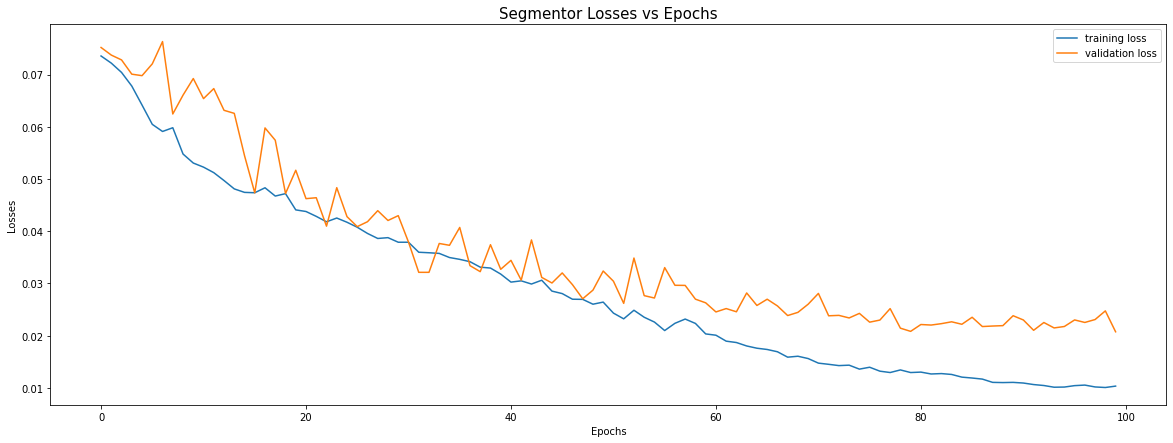

In [34]:
# summarize history for loss
plt.figure(figsize = (20,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Segmentor Losses vs Epochs', fontsize = 15)
# save loss plot
plt.savefig('/content/gdrive/MyDrive/Projects/Breast-Cancer-Ultrasound-Segmentation/plots/segmentor_loss_plot.png')

### Predictions

In [35]:
loss = model.evaluate(X_test, y_test)
print('Model overall validation loss: ', loss)

2/2 [==============================] - 5s 2s/step - loss: 0.0207
Model overall validation loss:  0.02073884941637516


In [36]:
y_pred = model.predict(X_test)

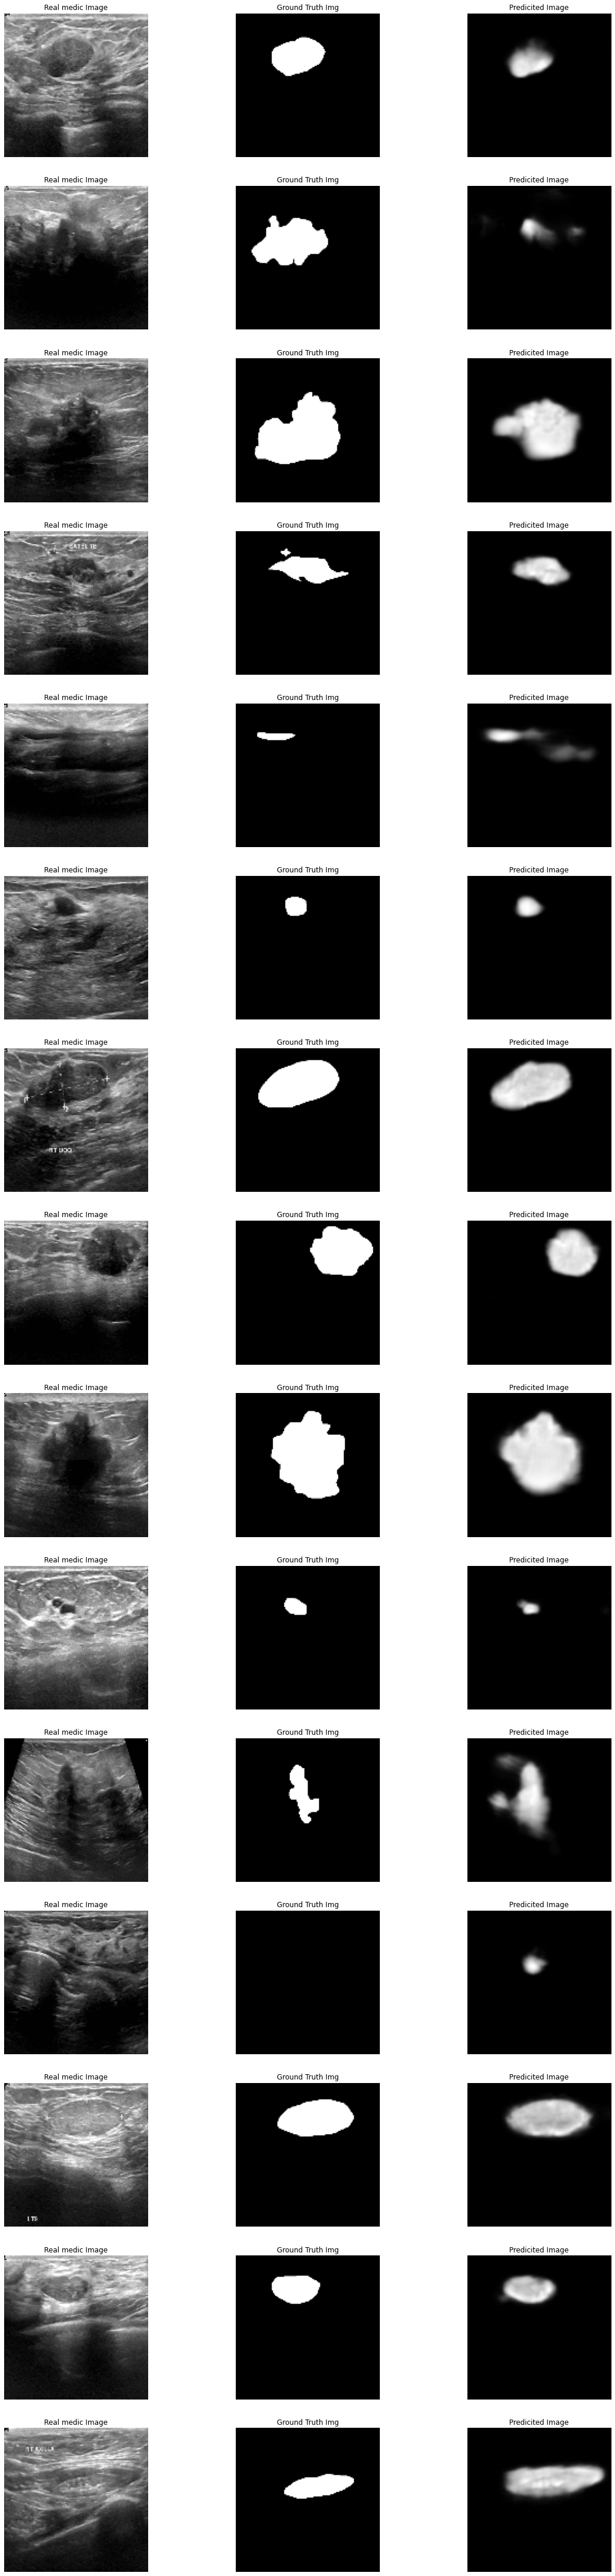

In [37]:
plt.figure(figsize = (20,80))

i = 0
x = 0
while i < 45 :
    
    plt.subplot(15,3,i+1)
    plt.imshow(tf.squeeze(X_test[x]), 'gray')
    plt.title('Real medic Image')
    plt.axis('off')
    
    plt.subplot(15,3,i+2)
    plt.imshow(tf.squeeze(y_test[x]), 'gray')
    plt.title('Ground Truth Img')
    plt.axis('off')
    
    plt.subplot(15,3,i+3)
    plt.imshow(tf.squeeze(y_pred[x]), 'gray')
    plt.title('Predicited Image')
    plt.axis('off')
    
    x += 1
    i += 3
plt.show()

## Save Segmentation Model

In [38]:
model.save('/content/gdrive/MyDrive/Projects/Breast-Cancer-Ultrasound-Segmentation/breast_segmentor_unet.h5')